This is a workbook to play around with preprocessing data.

In [1]:
'''This is my setup block.'''
from sqlalchemy import create_engine #SQL
from sqlalchemy_utils import database_exists, create_database #SQL
import psycopg2 #SQL
import pandas as pd #SQL, python

import numpy as np #sklearn
import matplotlib.pyplot as plt #sklearn
from sklearn.model_selection import train_test_split #sklearn

from sklearn.tree import DecisionTreeRegressor #sklearn decision tree
from sklearn.ensemble import RandomForestRegressor #random forest
from sklearn.multioutput import MultiOutputRegressor #random forest
from sklearn.decomposition import PCA #PCA

import pickle #for saving off a trained model

import time #python
from datetime import date
start = time.mktime(time.localtime())

%matplotlib inline

dbname = 'steamspy'
username = 'alan'
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))

seed = 6072 #np.random.randint(0,high=10000)
print("random seed:",seed)

random seed: 6072


In [9]:
#This block has new ways to calculate newowners based on averages instead of single-date differences
#2 weeks worth of seconds is 1123200000
#twoweeks_before_sale = 1496966400000 # or just use "> 1496880000000"
#sale_start = 1498089600000 #last day before sale
#sale_end = 1499212800000 #last day of sale
#twoweeks_after_sale = 1500336600000

'''
progress = 0
for appid in appids['appid']:
    owners_df = pd.DataFrame(columns=['appid','preowners','postowners','newowners'])
    owners_df['appid'] = [appid]
    
    sql_query = """SELECT AVG("Owners") FROM indie_timeseries WHERE seconds >= 1496966400000 and seconds <= 1498089600000 AND appid = %s""" % appid
    owners_df['preowners'] = pd.read_sql_query(sql_query,engine)

    sql_query = """SELECT AVG("Owners") FROM indie_timeseries WHERE seconds >= 1499212800000 and seconds <= 1500336600000 AND appid = %s""" % appid
    owners_df['postowners'] = pd.read_sql_query(sql_query,engine)
    
    owners_df['newowners'] = owners_df['postowners'] - owners_df['preowners']
    #owners_df.to_sql('indie_prices', engine, if_exists='append') #store this so I don't have to re-run it
    #print(owners_df)
    
    progress += 1
    if progress % 100 == 0:
        print("progress:",progress)
print("Done!")
'''

'\nprogress = 0\nfor appid in appids[\'appid\']:\n    owners_df = pd.DataFrame(columns=[\'appid\',\'preowners\',\'postowners\',\'newowners\'])\n    owners_df[\'appid\'] = [appid]\n    \n    sql_query = """SELECT AVG("Owners") FROM indie_timeseries WHERE seconds >= 1496966400000 and seconds <= 1498089600000 AND appid = %s""" % appid\n    owners_df[\'preowners\'] = pd.read_sql_query(sql_query,engine)\n\n    sql_query = """SELECT AVG("Owners") FROM indie_timeseries WHERE seconds >= 1499212800000 and seconds <= 1500336600000 AND appid = %s""" % appid\n    owners_df[\'postowners\'] = pd.read_sql_query(sql_query,engine)\n    \n    owners_df[\'newowners\'] = owners_df[\'postowners\'] - owners_df[\'preowners\']\n    #owners_df.to_sql(\'indie_prices\', engine, if_exists=\'append\') #store this so I don\'t have to re-run it\n    #print(owners_df)\n    \n    progress += 1\n    if progress % 100 == 0:\n        print("progress:",progress)\nprint("Done!")\n'

In [2]:
def no_neg(x):
    return(max(round(x,0),0))

#store this in SQL so I can more easily pull it later without having to reprocess
sql_query = '''SELECT * FROM indie_prices;'''
owners_df = pd.read_sql_query(sql_query,engine)
owners_df.drop(['index'],axis = 1,inplace = True)    
owners_df['preowners'] = owners_df['preowners'].apply(no_neg)
owners_df['postowners'] = owners_df['postowners'].apply(no_neg)
owners_df['newowners'] = owners_df['newowners'].apply(no_neg)
print(owners_df)
#print(appids)
#print("Done!")

       appid  preowners  postowners  newowners
0       1002    35645.0     37927.0     2282.0
1     102200   120386.0    119412.0        0.0
2     102400    35316.0     35452.0      136.0
3     102600  1527354.0   1540094.0    12740.0
4     102810    42360.0     44083.0     1723.0
5     102840   606762.0    604751.0        0.0
6     102850    47238.0     45461.0        0.0
7     104000    86868.0     87097.0      228.0
8     104020    48172.0     48873.0      701.0
9     104100    18734.0     19197.0      463.0
10    104200   697936.0    690125.0        0.0
11    104900  2380648.0   2391835.0    11187.0
12    105000   292948.0    295830.0     2882.0
13    105100   103915.0    105386.0     1471.0
14    105300   122433.0    116663.0        0.0
15    105420    61312.0     60889.0        0.0
16    105600  8642025.0   8839904.0   197879.0
17    105700    80314.0     86740.0     6426.0
18    105800   303475.0    305221.0     1746.0
19    107100  2428997.0   2465333.0    36336.0
20    107200 

This next section handles my database calls. I also want to remove "free" games from my dataset, since they (presumably) use a different revenue model for which I can't get data. The reporting numbers are just a sanity check to see how many titles I pull out. Right now, they're about 7500, which is enough to make me reasonably happy I can do something with the data.

In [24]:
#pull from DB:steamspy TABLE:indie_timeseries
#do some data preprocessing to create a usable pandas dataframe that I can feed into sklearn

'''pull presale data'''
sql_query = '''SELECT * FROM indie_timeseries WHERE seconds = 1498089600000 AND "Price" > 0;'''
presale = pd.read_sql_query(sql_query,engine)
presale.drop(['index','seconds','Owners','Price'],axis=1,inplace=True) #drop columns w/o useful data

print("presale:",len(presale)) #debug: how many records did I pull?

#pull saleprice data
sql_query = '''SELECT appid,"Price" FROM indie_timeseries WHERE seconds = 1499212800000 AND "Price" > 0;'''
saleprice = pd.read_sql_query(sql_query,engine)
saleprice.rename(columns={'Price': 'saleprice'}, inplace=True)
print("saleprice:",len(saleprice)) #debug: how many records did I pull?

sql_query = '''SELECT * FROM indie_games WHERE "price" > 0;'''
indies = pd.read_sql_query(sql_query,engine)
indies.drop(['index','ccu','owners'],axis=1,inplace=True) #these are all duplicates
indies.drop(['owners_variance','players_forever_variance','players_2weeks_variance'],axis=1,inplace=True) #these are probably not useful
indies.drop(['players_2weeks','average_2weeks','median_2weeks'],axis=1,inplace=True) #these are probably not useful

epoch = date(1970, 1, 1)
def to_seconds(dt):
    if dt:
        return((dt-epoch).total_seconds())
    else:
        return(None)
sql_query = '''SELECT * FROM indie_releasedates;'''
indie_dates = pd.read_sql_query(sql_query,engine)
indie_dates.drop(['index'],axis=1,inplace=True) #drop columns w/o useful data
indie_dates['release_mo_sec'] = indie_dates['release'].apply(to_seconds)
print("indie_dates:",len(indie_dates))
#print(indie_dates)

presale: 7590
saleprice: 7627
indie_dates: 8546


In this next block, I do a Principal Component Analysis of all tags in the database and generate a transformation model that I can apply to my training and test sets. Note that because I'm saving it off into the DB, I don't actually have to re-run it on my test cases, but I'm saving it off anyway in case I want to rerun it on fresh/unknown data.

In [37]:
#do tag processing
#example: PCA(n_components=None, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)

from sklearn.decomposition import PCA

def all_hot(ser):
    return(ser.apply(one_hot))
def one_hot(tag):
    if tag > 0:
        return(1)
    else:
        return(0)

def normalize(ser):
    max_tag = max(ser)
    return(max_tag)

def count(ser):
    return(ser.sum())

sql_query = '''SELECT * FROM indie_games_tags;'''
indie_tags = pd.read_sql_query(sql_query,engine)
indie_tags.drop(['index'],axis=1,inplace=True) #drop columns w/o useful data
indie_tags.fillna(value=0,inplace=True)
#print(indie_tags)

temp = indie_tags['appid']
indie_tags.drop(['appid'],axis=1,inplace=True)
#This line is for processing tag data
#indie_tags = indie_tags.apply(normalize) #attempt to normalize data, doesn't work yet
best_tags = indie_tags.apply(count).drop('Indie').nlargest(n=33,keep='first') #ignore "Indie" tag
best_list = list(best_tags.index)

#This block just gets the 33 most populous tags
indie_pca = pd.DataFrame()
for tag in best_list:
    indie_pca[tag] = indie_tags[tag]

for index, row in indie_pca.iterrows():
    max_row = max(row)
    indie_pca.loc[index] = row/max_row
    
indie_pca['appid'] = indies['appid']
print("indie_pca:",len(indie_pca))

print(indie_pca)

'''
#This block does actual PCA
#pca = PCA(n_components=None) #'None' grabs all of it
#pca = PCA(n_components=33) #'33' gets me most of the variance I want in my model
#pca.fit(indie_tags)
#indie_pca = pd.DataFrame(pca.transform(indie_tags))
'''

#Great, I think it worked?!
print("Done!")

indie_pca: 8546
        Action  Adventure  Multiplayer  Singleplayer  Survival  Early Access  \
0          NaN        NaN          NaN           NaN       NaN           NaN   
1     0.000000   0.625000     0.000000      0.350000  0.000000           0.0   
2          NaN        NaN          NaN           NaN       NaN           NaN   
3     1.000000   0.076923     0.108597      0.479638  0.000000           0.0   
4     1.000000   0.960000     0.000000      0.000000  0.000000           0.0   
5     1.000000   0.495327     0.000000      0.074766  0.000000           0.0   
6     1.000000   0.941176     0.000000      0.000000  0.000000           0.0   
7     0.000000   0.000000     0.000000      0.000000  0.000000           0.0   
8     0.000000   0.000000     0.000000      0.000000  0.000000           0.0   
9     1.000000   0.000000     0.000000      0.000000  0.000000           0.0   
10    0.344262   0.934426     0.114754      0.622951  0.114754           0.0   
11    0.561404   0.06315

In [88]:
#import cPickle
# save the pca model
#with open('saved_pca.pkl', 'wb') as fid:
#    pickle.dump(pca, fid)    

#Can load it again later with this code
#with open('saved_pca.pkl', 'rb') as fid:
#    pca = pickle.load(fid)
print("Done!")

Done!


([<matplotlib.axis.YTick at 0x7feec004fcc0>,
 <a list of 11 Text yticklabel objects>)

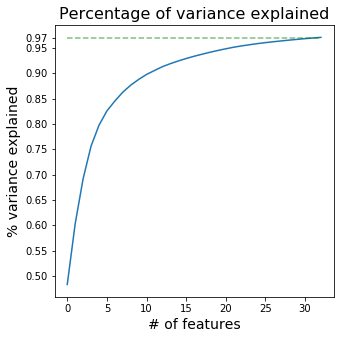

In [107]:
#plt.plot(pca.components_[0,:]) #This plots variance explained by Nth column in PCA matrix (i.e. [N,:])

#This plots PCA component 1 vs PCA component 2, to see if there's clustering that might show variance
#pc1 = indie_pca.iloc[:,0]
#pc2 = indie_pca.iloc[:,1]
#plt.scatter(pc1,pc2)

#Here's a plot to show how much cumulative variance is explained by each of my PCA components.
xrange = 33 #xrange should match cutoff, i.e. out of xrange0 (see above)

plt.plot(np.arange(xrange),pca.explained_variance_ratio_.cumsum()) 
plt.rcParams["figure.figsize"] = [5,5]

#plt.plot(np.arange(xrange), [.97] * xrange, color="green")

plt.xlabel("# of features", fontsize = '14')
plt.ylabel("% variance explained", fontsize = '14')
plt.title("Percentage of variance explained", fontsize = '16')

#plt.annotate(round(pca.explained_variance_ratio_.cumsum()[32],3), (30,.975))
yfinal = round(pca.explained_variance_ratio_.cumsum()[32],2)
plt.plot(np.arange(xrange),[yfinal]*xrange,
        linestyle='--', color = "green", alpha = .5)

y_vals = np.arange(.5,1,.05).tolist()
y_vals.append(yfinal)
#print("y_vals", type(y_vals), y_vals) #debug
plt.yticks(y_vals)

(0, 9)

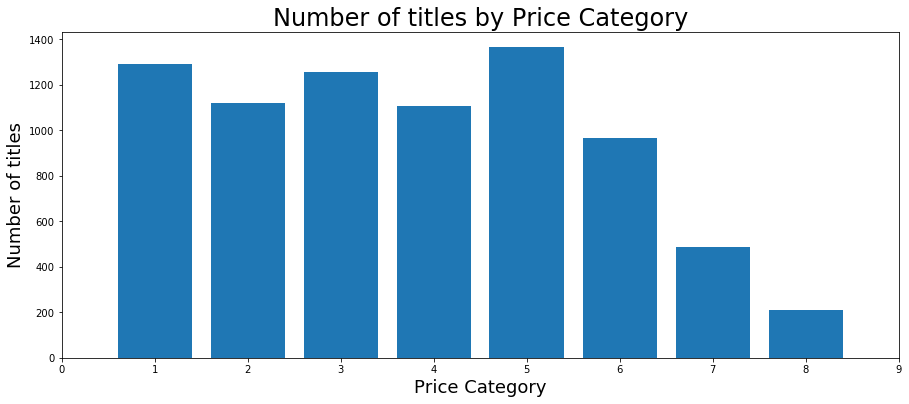

In [20]:
#pricemap is a category mapping for prices
#$0-$5 is category 1, etc.
#pricemap = {30:6,25:5,20:4,15:3,10:2,5:1} #should be descending
pricemap = {20.0:7,
            15.0:6,
            10.0:5,
            9.9:4,
            5.0:3,
            4.9:2,
            2.0:1}

def price_cat(price):
    category = len(pricemap) + 1
    for cap in pricemap:
        if float(price) < cap:
            category = pricemap[cap]
    return(category)

indie_cat = pd.DataFrame(indies['price'].apply(price_cat))
indie_cat['appid'] = indies['appid']
indie_cat.rename(columns={'price': 'price_category'}, inplace=True)
#print(indie_cat)

#Let's do some data exploration with matplotlib.pyplot as plt

count_prices = indie_cat['price_category'].value_counts().sort_index()
count_df = pd.DataFrame({'price_category':count_prices.index, 'count':count_prices.values})
plt.rcParams["figure.figsize"] = [15,6]

fig,ax = plt.subplots()
ax.set_xlabel('Price Category', fontsize = '18')
ax.set_ylabel('Number of titles', fontsize = '18')

ax.set_title('Number of titles by Price Category', fontsize = '24')

plt.bar(count_df['price_category'],count_df['count'],width=0.8)

plt.xlim([0,len(pricemap) + 2])


In [40]:
def clean_log(x):
    if x < 0:
        return(0)
    else:
        return(int(x))

'''merge everything, keyed on appid '''
all_indies = owners_df.merge(presale, on='appid', how='inner')
all_indies = all_indies.merge(saleprice, on='appid', how='inner')
all_indies = all_indies.merge(indies, on='appid', how='inner')
all_indies = all_indies.merge(indie_dates, on='appid', how='inner')
#all_indies = all_indies.merge(indie_cat, on='appid', how='inner') #price category
all_indies['salerevenue'] = all_indies['newowners'] * all_indies['saleprice'] #approximate revenue is newowners * SalePrice

#all_indies = all_indies.merge(indie_tags, on='appid', how='inner')
all_indies = all_indies.merge(indie_pca, on='appid', how='inner')
all_indies.fillna(value=0,inplace=True)

#post-process the data a little bit, insert a "revenue" column into dataframe
   
droplist = ['Players in two weeks','Average time per player','Median time per player','Players total']
all_indies.drop(droplist,axis=1,inplace=True) #drop columns w/o useful data
all_indies.rename(columns={'Views in the last week': 'views_week'}, inplace=True)

#all_indies['revenue_category'] = revenue.apply(np.log10).apply(clean_log) #could use log10 model of revenue as categorical
#print(all_indies['revenue_category']) #debug: for inspection purposes
print("all_indies:",len(all_indies))
list(all_indies)

all_indies: 7573


['appid',
 'preowners',
 'postowners',
 'newowners',
 'PCCU',
 'HCCU',
 'views_week',
 'saleprice',
 'name',
 'developer',
 'publisher',
 'score_rank',
 'players_forever',
 'average_forever',
 'median_forever',
 'price',
 'release',
 'release_mo_sec',
 'salerevenue',
 'Action',
 'Adventure',
 'Multiplayer',
 'Singleplayer',
 'Survival',
 'Early Access',
 'Simulation',
 'Strategy',
 'Open World',
 'RPG',
 'Casual',
 'Free to Play',
 'Sandbox',
 'First-Person',
 'Co-op',
 'Great Soundtrack',
 'Crafting',
 '2D',
 'Atmospheric',
 'Horror',
 'Building',
 'Funny',
 'Pixel Graphics',
 'Platformer',
 'FPS',
 'Zombies',
 'Shooter',
 'Puzzle',
 'Difficult',
 'Exploration',
 'Story Rich',
 'Comedy',
 'Massively Multiplayer']

Almost done with the data preprocessing. I just need to account for variance in the owner counts (basically, owner numbers shouldn't drop) and add back in 'revenue' (newowners * price). 

For my MVP, I'm going to try and classify games by "revenue category" which is loosely speaking, just a log10 of estimated revenue over the sale period of 2 weeks.

In [41]:
#store this in SQL so I can more easily pull it later without having to reprocess
#Note: I need a way better pre-sale owners estimator, maybe the mean of all points before sale dates?

all_indies.to_sql('indie_demo', engine, if_exists='replace')
print("Done!")

Done!


Now I have a dataframe that I can put into a model, so go ahead and use sklearn to do that.

Here's some sample code for a decision tree with multiple outputs. http://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression_multioutput.html

In [20]:
finish = time.mktime(time.localtime())
runtime = finish - start
print("Finished processing in",runtime,"seconds!")

Finished processing in 1489.0 seconds!
